Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(44600, 30, 218)
Epoch 1/1000
975/976 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0093 - loss: 9.7736
Epoch 1: val_loss improved from inf to 8.76226, saving model to /content/drive/MyDrive/pickle/cnn+gru_best_model.keras
976/976 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.0094 - loss: 9.7730 - val_accuracy: 0.0594 - val_loss: 8.7623 - learning_rate: 1.0000e-04
Epoch 2/1000
974/976 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0496 - loss: 8.7545
Epoch 2: val_loss improved from 8.76226 to 7.86919, saving model to /content/drive/MyDrive/pickle/cnn+gru_best_model.keras
976/976 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.0496 - loss: 8.7539 - val_accuracy: 0.1491 - val_loss: 7.8692 - learning_rate: 1.0000e-04
Epoch 3/1000
972/976 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1186 - loss: 7.9416
Epoch 3: val_loss improved from 7.86919 to 7.06460,

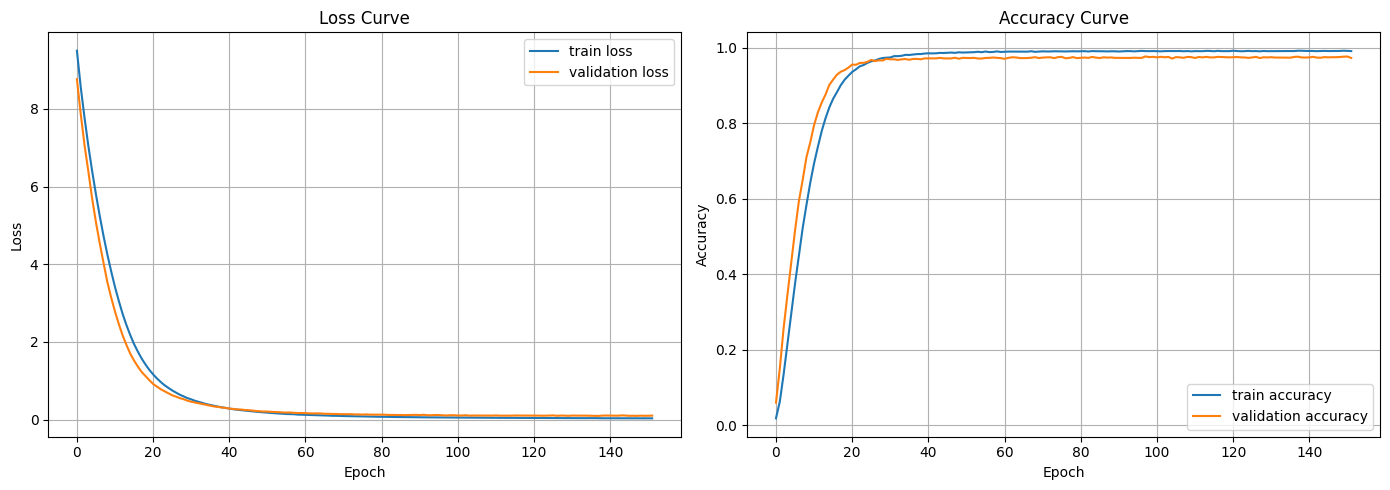

In [5]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from google.colab import drive
from keras import optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import GRU, Dense, Bidirectional
from tensorflow.keras.regularizers import l2

import keras

def Normalize(X):
  from sklearn.preprocessing import StandardScaler
  X_reshaped = X.reshape(-1, X.shape[-1])
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X_reshaped)
  X_scaled = X_scaled.reshape(X.shape)
  return X_scaled

drive.mount('/content/drive')
pickle_path = '/content/drive/MyDrive/pickle'
txt_path = os.path.join(pickle_path, 'kelimeler.txt')

with open(txt_path, 'r', encoding='utf-8') as f:
    kelime_listesi = [line.strip() for line in f if line.strip()]
numclass = len(kelime_listesi)

X = pickle.load(open(os.path.join(pickle_path, "X446Y_hands.pickle"), "rb"))
Y = pickle.load(open(os.path.join(pickle_path, "Y446Y_hands.pickle"), "rb"))
print(X.shape)
X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, stratify=Y_train, random_state=42)

X_train = Normalize(X_train)
X_val = Normalize(X_val)
X_test = Normalize(X_test)

# One-hot encoding
Y_train = to_categorical(Y_train, num_classes=numclass)
Y_val = to_categorical(Y_val, num_classes=numclass)
Y_test = to_categorical(Y_test, num_classes=numclass)

#CNN+GRU Model
model = Sequential()
dropval = 0.3

model.add(Conv1D(512, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv1D(512, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(dropval))
model.add(GRU(512, return_sequences=False))
model.add(Dropout(dropval))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(numclass, activation='softmax'))

# --- Select Optimizer ---
k = 4
if (k == 0): opt = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.9)
if (k == 1): opt = keras.optimizers.Adadelta(learning_rate=0.01)
if (k == 2): opt = optimizers.SGD(learning_rate=0.001, clipnorm=1.)
if (k == 3): opt = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9, decay=0.0)
if (k == 4): opt = keras.optimizers.Adamax(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
if (k == 5): opt = keras.optimizers.Nadam(learning_rate=0.0004, beta_1=0.9, beta_2=0.999)
if (k == 6): opt = optimizers.AdamW(learning_rate=0.0001, beta_1=0.9, beta_2=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# --- CALLBACKS ---
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/pickle/cnn+gru_best_model.keras',
                                   monitor='val_loss', save_best_only=True, verbose=1)
# --- Train Time trace ---
start_time = time.time()

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

end_time = time.time()
training_duration = end_time - start_time

# --- Test Evaluation ---
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"\n Test Accuracy: {test_accuracy:.4f}")
print(f"\n Test Loss: {test_loss:.4f}")
print(f"\n Train Time: {training_duration:.2f} saniye")
print(f"\n Total Parameters: {model.count_params()}")

Y_pred = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

f1_macro = f1_score(Y_true_labels, Y_pred_labels, average='macro')
print(f"F1-Macro Skoru: {f1_macro:.4f}")

result = classification_report(Y_true_labels, Y_pred_labels, digits=4, output_dict=False)
print(result)

# Accuracy and Loss Curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
X[0].shape

(30, 218)